In [9]:
import numpy as np
from scipy.ndimage import correlate
from skimage import color
import matplotlib.pyplot as plt
import cv2

# Q1 Harris corner detection

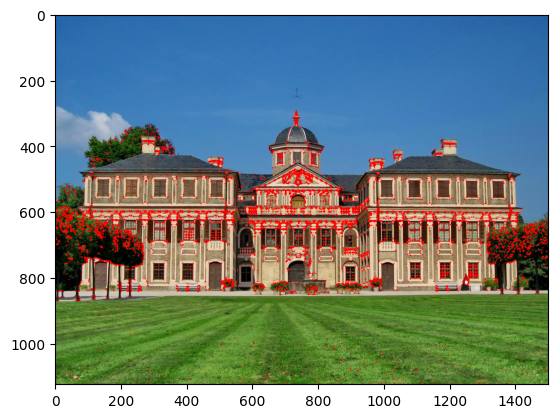

In [10]:
gaussian_filter = np.array([[0.25,1,0.25],
                            [1,4,1],
                            [0.25,1,0.25]])

def compute_gradient(image: np.ndarray) -> np.ndarray:
    if len(image.shape) > 2:
        image = color.rgb2gray(image)
    
    sobel_x = np.array([[-1, 0, 1], 
                        [-2, 0, 2], 
                        [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1], 
                        [0, 0, 0], 
                        [-1, -2, -1]])

    gradient_x = correlate(image, sobel_x, mode='constant')
    gradient_y = correlate(image, sobel_y, mode='constant')

    return gradient_x, gradient_y


def detect_harris_corner(image: np.ndarray, threshold: float = 0.01):
    if len(image.shape) > 2:
        image = color.rgb2gray(image)

    # compute gradients
    gradient_x, gradient_y = compute_gradient(image)
    gradient_x2, gradient_y2 = gradient_x * gradient_x, gradient_y * gradient_y
    gradient_xy = gradient_x * gradient_y

    #average gradients using gaussian filter
    gradient_x2 = correlate(gradient_x2, gaussian_filter, mode='constant')
    gradient_y2 = correlate(gradient_y2, gaussian_filter, mode='constant')
    gradient_xy = correlate(gradient_xy, gaussian_filter, mode='constant')
    
    # harris response matrix
    det = (gradient_x2 * gradient_y2) - (gradient_xy ** 2)
    trace = gradient_x2 + gradient_y2
    harris_response = det - 0.05 * (trace ** 2)
    
    # non-maximum suppression
    corners = np.argwhere(harris_response > threshold * harris_response.max())
    corners = np.array([corners[:, 1], corners[:, 0]]).T
    return corners


original_image = plt.imread('Assignment3/building.jpg')
corners = detect_harris_corner(original_image, threshold=0.01)

display_image = original_image.copy()

for corner in corners:
    x, y = corner
    cv2.circle(display_image, (x, y), radius=1, color=(255, 0, 0))

plt.imshow(display_image)
plt.show()

# Q2 (a) Feature Extraction

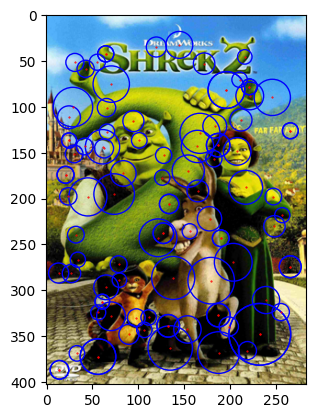

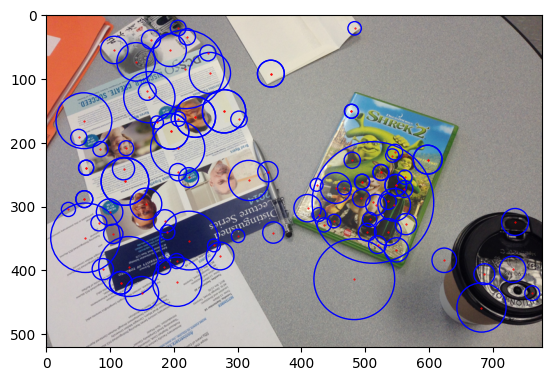

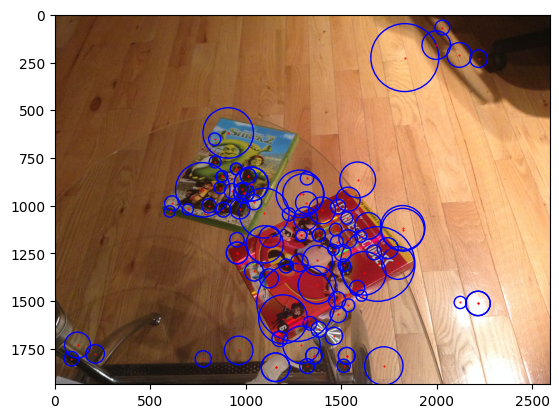

In [11]:
def extract_feature(image: np.ndarray):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    gray_image = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    return keypoints, descriptors

def visualize_keypoints(image: np.ndarray, keypoints: tuple, num_keypoints: int = 100):
    fig, ax = plt.subplots()
    keypoints = sorted(keypoints, key=lambda x : x.size, reverse=True)
    for i in range(num_keypoints):
        x, y = keypoints[i].pt
        ax.plot(x, y, 'r.', markersize=1)
        ax.add_patch(plt.Circle((x, y), radius=keypoints[i].size, color='blue', fill=False))

    plt.imshow(image)
    plt.show()
    

original_image = plt.imread('Assignment3/reference.png')
keypoints, descriptors = extract_feature(original_image)
visualize_keypoints(original_image, keypoints)

original_image = plt.imread('Assignment3/test.png')
keypoints, descriptors = extract_feature(original_image)
visualize_keypoints(original_image, keypoints)

original_image = plt.imread('Assignment3/test2.png')
keypoints, descriptors = extract_feature(original_image)
visualize_keypoints(original_image, keypoints)

# Q2 (b) Matching

# Matching algorithm desctiption #

##### Start by calculating the euclidean distance between all the features' descriptors from one image to all the features' descriptors from the other. I used np.linalg.norm function to do this optimally. #####
##### To select the best matches, I only select the features where the ratio between the smallest and second smallest euclidean dist is less than a predefined threshold. #####
##### Example: say A = min euclidean dist between feautre1 from image1 and feature3 from image2 and B = second smallest euclidean dist between feautre1 from image1 and feature4 from image2. We only consider feature1 from image1 and feature3 from image2 a match if A/B < threshold. #####

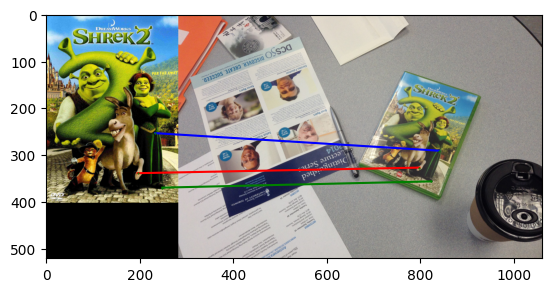

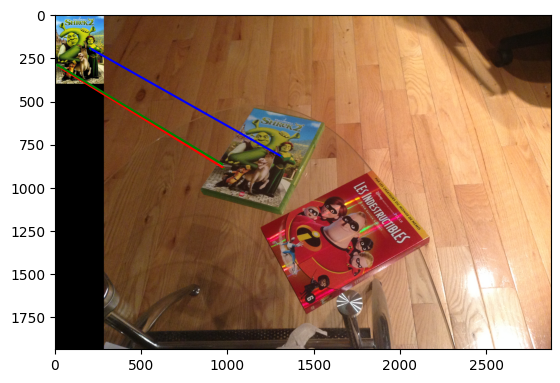

In [12]:
def match_features(descriptors1: np.ndarray, descriptors2: np.ndarray, threshold: float = 0.8):
    """ Matches the features using the ratio of euclidean distance between the closest and second closest keypoint
    """
    matches = []
    for i in range(descriptors1.shape[0]):
        distances = np.linalg.norm(descriptors2 - descriptors1[i], axis=1)
        closest, second_closest = np.argsort(distances)[:2]
        ratio = distances[closest] / distances[second_closest]
        if ratio < threshold:
            matches.append((i, closest, distances[closest]))
    return np.array(matches)
    

def visualize_matches(image1: np.ndarray, keypoints1: np.ndarray, image2: np.ndarray, keypoints2: np.ndarray, matches: np.ndarray, top_n: int = 3):
    """ Visualizes the matches between the two images
    """
    fig, ax = plt.subplots()
    if image1.shape[0] < image2.shape[0]:
        diff_rows = (image2.shape[0] - image1.shape[0])
        image1 = np.vstack((image1, np.zeros((diff_rows, image1.shape[1], 3))))
    elif image1.shape[0] > image2.shape[0]:
        diff_rows = (image1.shape[0] - image2.shape[0])
        image2 = np.vstack((image2, np.zeros((diff_rows, image2.shape[1], 3))))
        

    ax.imshow(np.hstack((image1, image2)))
    offset = image1.shape[1]
    matches = sorted(matches, key=lambda x: x[2])
    color_palette = ['r-', 'g-', 'b-', 'y-', 'c-', 'm-']
    for i in range(top_n):
        x1, y1 = keypoints1[int(matches[i][0])].pt
        x2, y2 = keypoints2[int(matches[i][1])].pt
        ax.plot([x1, x2 + offset], [y1, y2], color_palette[i], lw=1.5)
        ax.plot(x1, y1, 'g.', markersize=1)
        ax.plot(x2 + offset, y2, 'g.', markersize=1)
    plt.show()


reference_image = plt.imread('Assignment3/reference.png')
reference_keypoints, reference_descriptors = extract_feature(reference_image)

test_image = plt.imread('Assignment3/test.png')
test_keypoints, test_descriptors = extract_feature(test_image)
matches1 = match_features(reference_descriptors, test_descriptors)
visualize_matches(reference_image, reference_keypoints, test_image, test_keypoints, matches1)

test2_image = plt.imread('Assignment3/test2.png')
test2_keypoints, test2_descriptors = extract_feature(test2_image)
matches2 = match_features(reference_descriptors, test2_descriptors)
visualize_matches(reference_image, reference_keypoints, test2_image, test2_keypoints, matches2)

# Q2 (c) & (d) Affline transformation and visualization

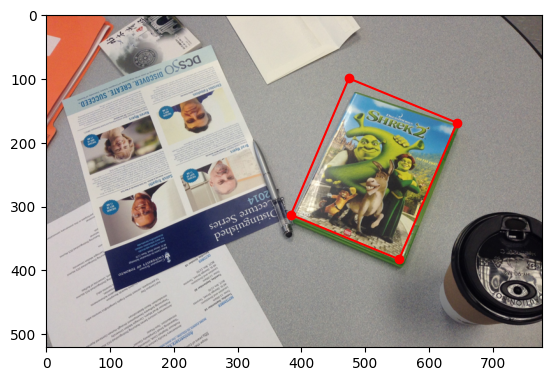

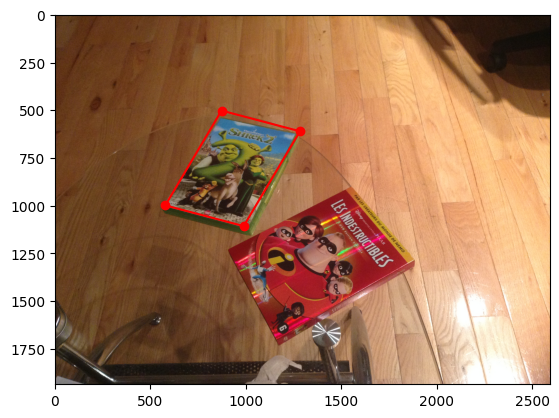

In [13]:
def affine_transform(reference_keypoints: np.ndarray, test_keypoints: np.ndarray, matches: np.ndarray, top_n: int = 3):
    """ Computes the affine transformation matrix using the matched keypoints
    """
    matches = sorted(matches, key=lambda x: x[2])
    reference_pts = np.array([reference_keypoints[int(m[0])].pt for m in matches[:top_n]]).reshape(-1, 2)
    transformed_pts = np.array([test_keypoints[int(m[1])].pt for m in matches[:top_n]]).reshape(-1, 2)

    P = np.zeros((top_n * 2, 6))
    P_bar = transformed_pts.flatten()
    for i in range(top_n):
        P[2*i] = [reference_pts[i][0], reference_pts[i][1], 0, 0, 1, 0]
        P[2*i + 1] = [0, 0, reference_pts[i][0], reference_pts[i][1], 0, 1]

    a = np.linalg.inv(P) @ P_bar
    fifth_item = a[4]
    a = np.insert(np.delete(a, 4, 0), 2, fifth_item)
    return a.reshape(2, 3)


def visualize_affine_transformation(reference_image, test_image, affine_matrix):
    reference_image_height, reference_image_width = reference_image.shape[:2]
    corners = np.float32([[0, 0], 
                          [reference_image_width, 0], 
                          [reference_image_width, reference_image_height],
                          [0, reference_image_height]])
    points = np.hstack([corners, np.ones((corners.shape[0], 1))])
    transformed_corners = np.dot(points, np.vstack([affine_matrix, [0, 0, 1]]).T)[:, :2]

    plt.imshow(test_image, cmap='gray')
    plt.plot(transformed_corners[:, 0], transformed_corners[:, 1], 'ro')
    for i, _ in enumerate(transformed_corners):
        plt.plot([transformed_corners[i][0], transformed_corners[(i+1)%4][0]], 
                 [transformed_corners[i][1], transformed_corners[(i+1)%4][1]], 'r-')
    plt.show()


reference_image = plt.imread('Assignment3/reference.png')
reference_keypoints, reference_descriptors = extract_feature(reference_image)

test_image = plt.imread('Assignment3/test.png')
test_keypoints, test_descriptors = extract_feature(test_image)
matches1 = match_features(reference_descriptors, test_descriptors)

affine_matrix = affine_transform(reference_keypoints, test_keypoints, matches1)
visualize_affine_transformation(reference_image, test_image, affine_matrix)

test_image = plt.imread('Assignment3/test2.png')
test_keypoints, test_descriptors = extract_feature(test_image)
matches1 = match_features(reference_descriptors, test_descriptors)

affine_matrix = affine_transform(reference_keypoints, test_keypoints, matches1)
visualize_affine_transformation(reference_image, test_image, affine_matrix)